In [1]:
import sys
sys.path.insert(0, '..')

import glob
import warnings
warnings.filterwarnings('ignore')

from matplotlib.patches import Patch
import polars as pl
import scipy
from scipy.spatial.distance import cdist

from src.data.io import read_df
from src.visualise.plot import *
from src.data.descriptors import dataframe_2_morgan

## Main Figures

### Main Figure 1: Design choices comparison

In [5]:
DPI = 300
HEIGHT_INCHES = 6
WIDTH_INCHES = 6.5

METRIC_SIZE = 18
METRIC_PAD = 24
LABEL_OFFSET = 0.01
LABEL_SIZE = 16
TITLE_SIZE = 22
TITLE_OFFSET = 1.25

Matplotlib is now using: Arial


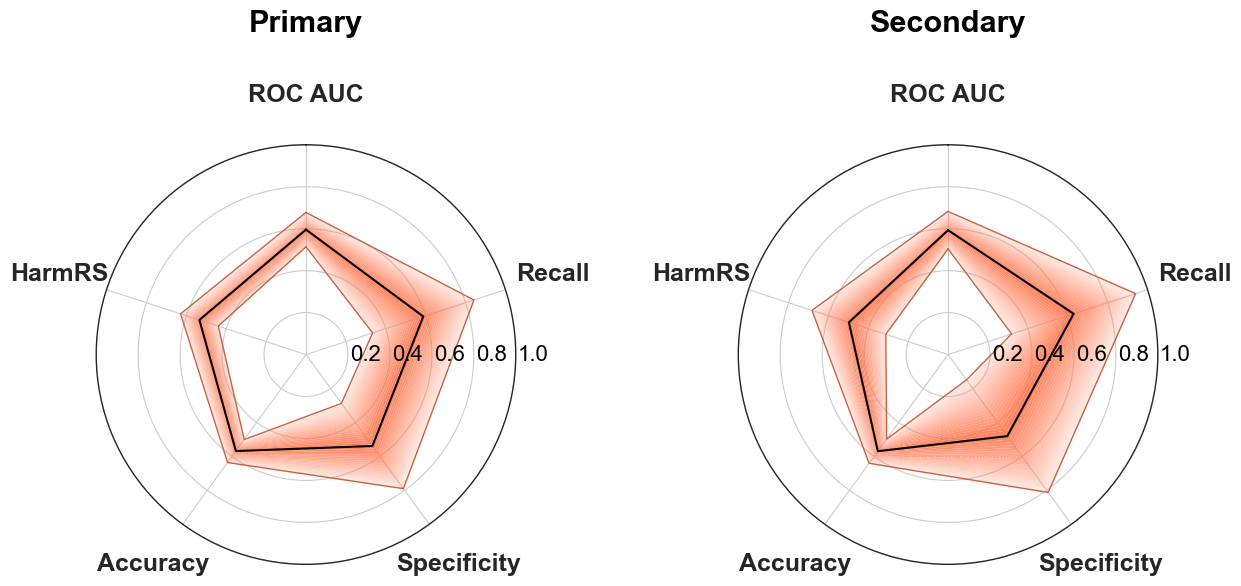

In [7]:
df = read_df('../results/comparison/dataset_type.tsv')

df['LowerCI'] = df['Mean'] - df['STD'] * 1.96
df['UpperCI'] = df['Mean'] + df['STD'] * 1.96

df = df[df['Metric'].isin(['Specificity', 'Recall', 'HarmRS', 'ROC AUC', 'Accuracy'])]

sns.set_context('paper', font_scale=1.1)
sns.set_style('white')
set_font('arial.ttf')

"""
set_font function requires adding the arial.ttf file to:
miniforge3/envs/environment/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/
You can get it, for example, from here: https://github.com/kavin808/arial.ttf/blob/master/arial.ttf
"""

metrics = ['ROC AUC', 'Recall', 'Specificity', 'Accuracy', 'HarmRS']
num_vars = len(metrics)

fig, axes = plt.subplots(1, 2, figsize=(WIDTH_INCHES*2, HEIGHT_INCHES), subplot_kw=dict(polar=True))

base_col = four_point_palette()[3]
cols = generate_color_variants(base_col, 4, step=0.3)

colors = {
    'Primary': {'line': base_col, 'fill': cols[-2]},
    'Secondary': {'line': base_col, 'fill': cols[-2]}
}

# Plot each radar plot separately
for idx, dataset in enumerate(['Primary', 'Secondary']):
    ax = axes[idx]
    ax.set_facecolor('white')

    # Set theta to start at top and go clockwise
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Extract required values
    subset = df[df['Dataset'] == dataset]

    mean_vals = [subset[subset['Metric'] == m]['Mean'].values[0] for m in metrics]
    lower_vals = [subset[subset['Metric'] == m]['LowerCI'].values[0] for m in metrics]
    upper_vals = [subset[subset['Metric'] == m]['UpperCI'].values[0] for m in metrics]

    standard_angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    standard_angles += standard_angles[:1]

    # Radar plot with gradient
    plot_gradient_radar(ax, standard_angles, mean_vals, lower_vals, upper_vals,
                        colors[dataset]['line'],
                        colors[dataset]['fill'],
                        dataset)

    # Styling
    ax.set_xticks(standard_angles[:-1])
    ax.set_xticklabels(metrics, size=METRIC_SIZE, fontweight='bold')
    ax.tick_params(axis='x', pad=METRIC_PAD)

    ax.set_ylim(0, 1)

    # Remove default ticks and labels
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([])

    # Add new labels
    radial_values = [0.2, 0.4, 0.6, 0.8, 1.0]
    label_angle = np.pi / 2 # offset

    for val in radial_values:
        ax.text(label_angle, val + LABEL_OFFSET, f'{val}',
                ha='left', va='center',
                fontsize=LABEL_SIZE, color='black',
                zorder=3)

    ax.set_title(f'{dataset}', size=TITLE_SIZE, fontweight='bold', y=TITLE_OFFSET,
                 color='black')

plt.tight_layout()
plt.savefig('../figures/1_1_Dataset_Type.png', dpi=300, bbox_inches=None,
            facecolor='white', edgecolor='none')
plt.show()

Matplotlib is now using: Arial


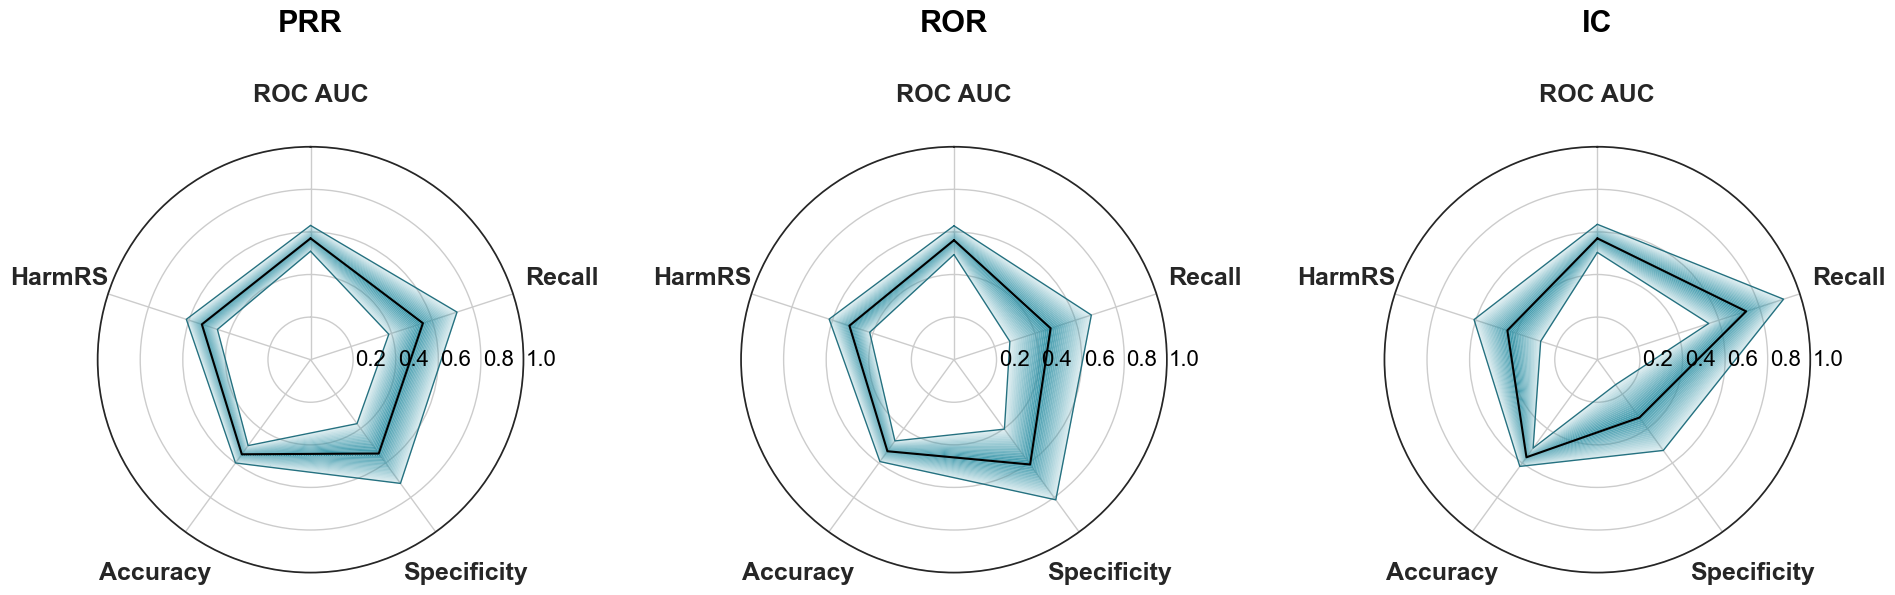

In [8]:
df = read_df('../results/comparison/dpa_metric.tsv')

df['LowerCI'] = df['Mean'] - df['STD'] * 1.96
df['UpperCI'] = df['Mean'] + df['STD'] * 1.96

df = df[df['Metric'].isin(['Specificity', 'Recall', 'HarmRS', 'ROC AUC', 'Accuracy'])]

sns.set_context('notebook', font_scale=1.1)
sns.set_style('white')
set_font('arial.ttf')

metrics = ['ROC AUC', 'Recall', 'Specificity', 'Accuracy', 'HarmRS']
num_vars = len(metrics)

fig, axes = plt.subplots(1, 3, figsize=(WIDTH_INCHES*3, HEIGHT_INCHES), subplot_kw=dict(polar=True))

base_col = four_point_palette()[0]
cols = generate_color_variants(base_col, 4, step=0.3)

colors = {
    'PRR': {'line': base_col, 'fill': cols[-2]},
    'ROR': {'line': base_col, 'fill': cols[-2]},
    'IC':  {'line': base_col, 'fill': cols[-2]}
}

for idx, dpa in enumerate(['PRR', 'ROR', 'IC']):
    ax = axes[idx]
    ax.set_facecolor('white')

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    subset = df[df['DPA'] == dpa]

    mean_vals = [subset[subset['Metric'] == m]['Mean'].values[0] for m in metrics]
    lower_vals = [subset[subset['Metric'] == m]['LowerCI'].values[0] for m in metrics]
    upper_vals = [subset[subset['Metric'] == m]['UpperCI'].values[0] for m in metrics]

    standard_angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    standard_angles += standard_angles[:1]

    plot_gradient_radar(ax, standard_angles, mean_vals, lower_vals, upper_vals,
                        colors[dpa]['line'],
                        colors[dpa]['fill'],
                        dpa)

    ax.set_xticks(standard_angles[:-1])
    ax.set_xticklabels(metrics, size=METRIC_SIZE, fontweight='bold')
    ax.tick_params(axis='x', pad=METRIC_PAD)

    ax.set_ylim(0, 1)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([])

    radial_values = [0.2, 0.4, 0.6, 0.8, 1.0]
    label_angle = np.pi / 2

    for val in radial_values:
        ax.text(label_angle, val + LABEL_OFFSET, f'{val}',
                ha='left', va='center',
                fontsize=LABEL_SIZE, color='black',
                zorder=3)

    ax.set_title(f'{dpa}', size=TITLE_SIZE, fontweight='bold', y=TITLE_OFFSET,
                 color='black')

plt.tight_layout()
plt.savefig('../figures/1_2_DPA_metric.png', dpi=300, bbox_inches=None,
            facecolor='white', edgecolor='none')
plt.show()


Matplotlib is now using: Arial


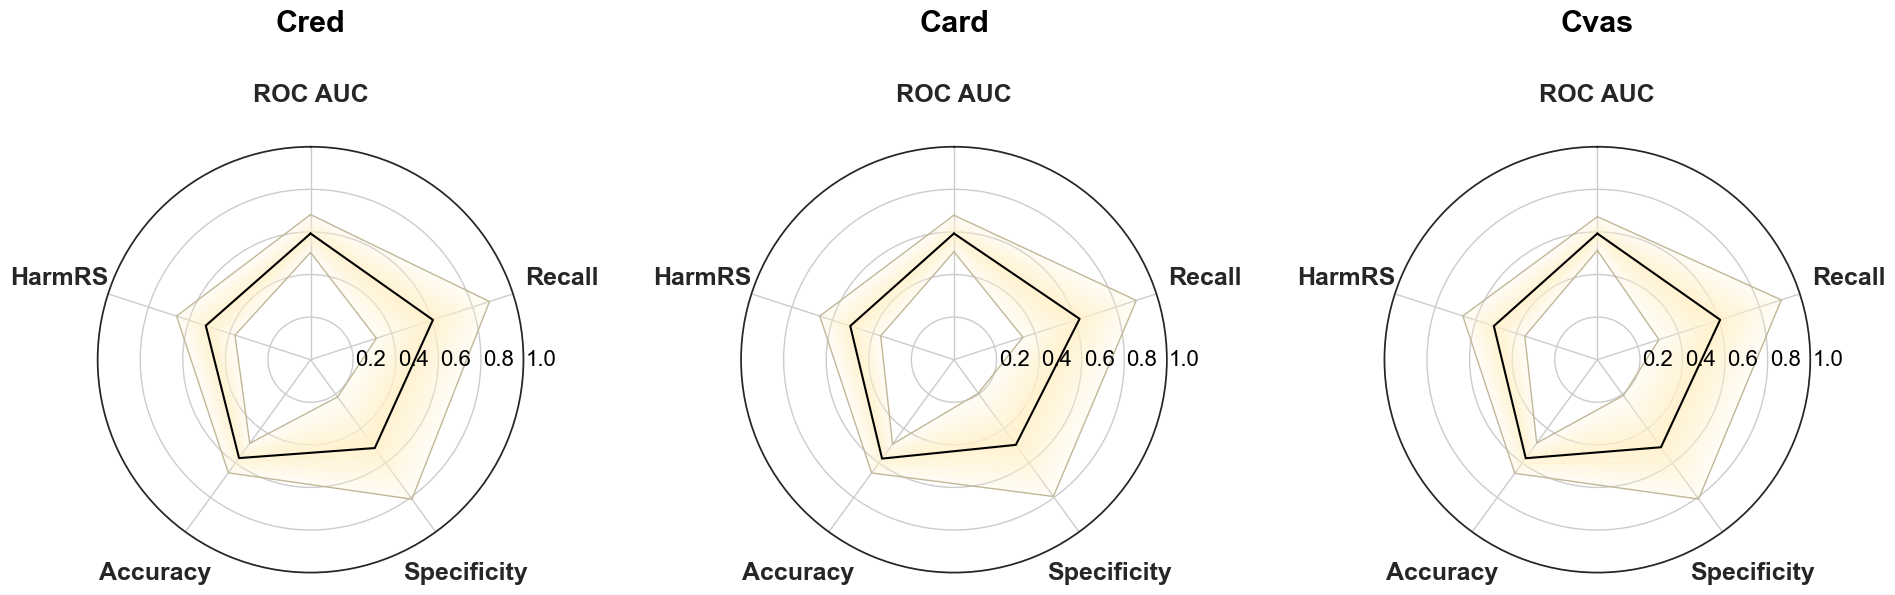

In [9]:
df = read_df('../results/comparison/pt_set.tsv')

df['LowerCI'] = df['Mean'] - df['STD'] * 1.96
df['UpperCI'] = df['Mean'] + df['STD'] * 1.96

df = df[df['Metric'].isin(['Specificity', 'Recall', 'HarmRS', 'ROC AUC', 'Accuracy'])]

sns.set_context('notebook', font_scale=1.1)
sns.set_style('white')
set_font('arial.ttf')

metrics = ['ROC AUC', 'Recall', 'Specificity', 'Accuracy', 'HarmRS']
num_vars = len(metrics)

fig, axes = plt.subplots(1, 3, figsize=(WIDTH_INCHES*3, HEIGHT_INCHES), subplot_kw=dict(polar=True))

base_col = four_point_palette()[1]
cols = generate_color_variants(base_col, 4, step=0.2)

colors = {
    'Cred': {'line': cols[1], 'fill': cols[-2]},
    'Card': {'line': cols[1], 'fill': cols[-2]},
    'Cvas': {'line': cols[1], 'fill': cols[-2]}
}

for idx, pt in enumerate(['Cred', 'Card', 'Cvas']):
    ax = axes[idx]
    ax.set_facecolor('white')

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    subset = df[df['PT'] == pt]

    mean_vals = [subset[subset['Metric'] == m]['Mean'].values[0] for m in metrics]
    lower_vals = [subset[subset['Metric'] == m]['LowerCI'].values[0] for m in metrics]
    upper_vals = [subset[subset['Metric'] == m]['UpperCI'].values[0] for m in metrics]

    standard_angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    standard_angles += standard_angles[:1]

    plot_gradient_radar(ax, standard_angles, mean_vals, lower_vals, upper_vals,
                        colors[pt]['line'],
                        colors[pt]['fill'],
                        pt)

    ax.set_xticks(standard_angles[:-1])
    ax.set_xticklabels(metrics, size=METRIC_SIZE, fontweight='bold')
    ax.tick_params(axis='x', pad=METRIC_PAD)

    ax.set_ylim(0, 1)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([])

    radial_values = [0.2, 0.4, 0.6, 0.8, 1.0]
    label_angle = np.pi / 2

    for val in radial_values:
        ax.text(label_angle, val + LABEL_OFFSET, f'{val}',
                ha='left', va='center',
                fontsize=LABEL_SIZE, color='black',
                zorder=3)

    ax.set_title(f'{pt}', size=TITLE_SIZE, fontweight='bold', y=TITLE_OFFSET,
                 color='black')

plt.tight_layout()
plt.savefig('../figures/1_3_PT_set.png', dpi=300, bbox_inches=None,
            facecolor='white', edgecolor='none')
plt.show()

### Main Figure 2: DICTrank comparison

In [ ]:
sns.set_context('notebook', font_scale=1.1)
sns.set_style('white')
set_font('arial.ttf')

drank = read_df('../data/dictrank/DICTrank_binary.parquet')[['SMILES', 'Class']]
drank = drank.rename(columns={'Class': 'Label_drank'})
rows = []

for idx, file in enumerate(glob.glob('../data/carbide/*/*/*.joblib')):
    _, _, _, dataset_type, pt_set, file_name = file.rstrip('.joblib').split('/')
    dataset_type = dataset_type.lstrip('_')
    dpa_metric = file_name.split('_')[1]
    df = read_df(file)[['SMILES', 'Signature', 'Label']]
    comp_tuple = ('Unknown', 'Unknown', 'Unknown')
    df = df[df['Signature'] == comp_tuple].reset_index(drop=True)
    df = df.rename(columns={'Label': 'Label_comp'})
    df = df.merge(drank.copy(), on='SMILES')

    tp = len(df[(df['Label_comp'] == 1) & (df['Label_drank'] == 1)])
    tn = len(df[(df['Label_comp'] == 0) & (df['Label_drank'] == 0)])
    fp = len(df[(df['Label_comp'] == 1) & (df['Label_drank'] == 0)])
    fn = len(df[(df['Label_comp'] == 0) & (df['Label_drank'] == 1)])

    row = pd.DataFrame({'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn], 'Dataset': [dataset_type.capitalize()],
                        'DPA': [dpa_metric.upper()], 'PT': [pt_set.capitalize()]})
    rows.append(row)

df = pd.concat(rows, axis=0).reset_index(drop=True)

melt_df = pd.melt(df, id_vars=['Dataset', 'DPA', 'PT'], value_vars=['TP', 'TN', 'FP', 'FN'], var_name='Category', value_name='Count')

colors = {
    'TP': '#257180',
    'TN': '#F2E5BF',
    'FP': '#FD8B51',
    'FN': '#CB6040'
}

dpa_metrics = ['PRR', 'ROR', 'IC']
pt_sets = ['Cred', 'Card', 'Cvas']

dpa_dtype = pd.CategoricalDtype(dpa_metrics, ordered=True)
pt_dtype = pd.CategoricalDtype(pt_sets, ordered=True)

melt_df = melt_df.astype({"DPA": dpa_dtype, "PT": pt_dtype})

g = sns.FacetGrid(melt_df, row='Dataset', col='PT')

for ax in g.axes.flatten():
    title = str(ax.title).split(',')[-1].rstrip("')").lstrip("'")
    dataset, pt = title.split(' | ')
    dataset = dataset.split(' = ')[-1]
    pt = pt.split(' = ')[-1]

    # Filter the DataFrame for the current dataset and PT
    subset = melt_df[(melt_df['Dataset'] == dataset) & (melt_df['PT'] == pt)]

    x_positions = range(len(dpa_metrics))

    for i, dpa in enumerate(dpa_metrics):
        bottom = 0
        for category in ['TN', 'FN', 'FP', 'TP']:
            count = subset[(subset['Category'] == category) & (subset['DPA'] == dpa)]['Count']
            if not count.empty:
                ax.bar(i, count.values[0], bottom=bottom, width=0.75,
                       alpha=1,
                       color=colors.get(category))
                bottom += count.values[0]  # update the bottom for the next category
                ax.text(i, bottom - count.values[0] / 2, str(count.values[0]), ha='center', va='center', color='black', size=8)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(dpa_metrics)

legend_patches = [Patch(color=colors[category], label=f'{category} ({category})') for category in ['TP', 'FP', 'FN', 'TN']]

legend_labels = ['TP', 'FP', 'FN', 'TN']

g.figure.legend(legend_patches, legend_labels, title='Categories', loc='upper right', bbox_to_anchor=(1.125, 1), bbox_transform=g.figure.transFigure)

plt.savefig('../figures/2_DICTrank_Comparison.png', dpi=300, bbox_inches='tight')

plt.show()

### Main Figure 3: Model results on Primary-PRR-Cred variant

✔ Matplotlib is now using: Arial
✔ Matplotlib is now using: Arial


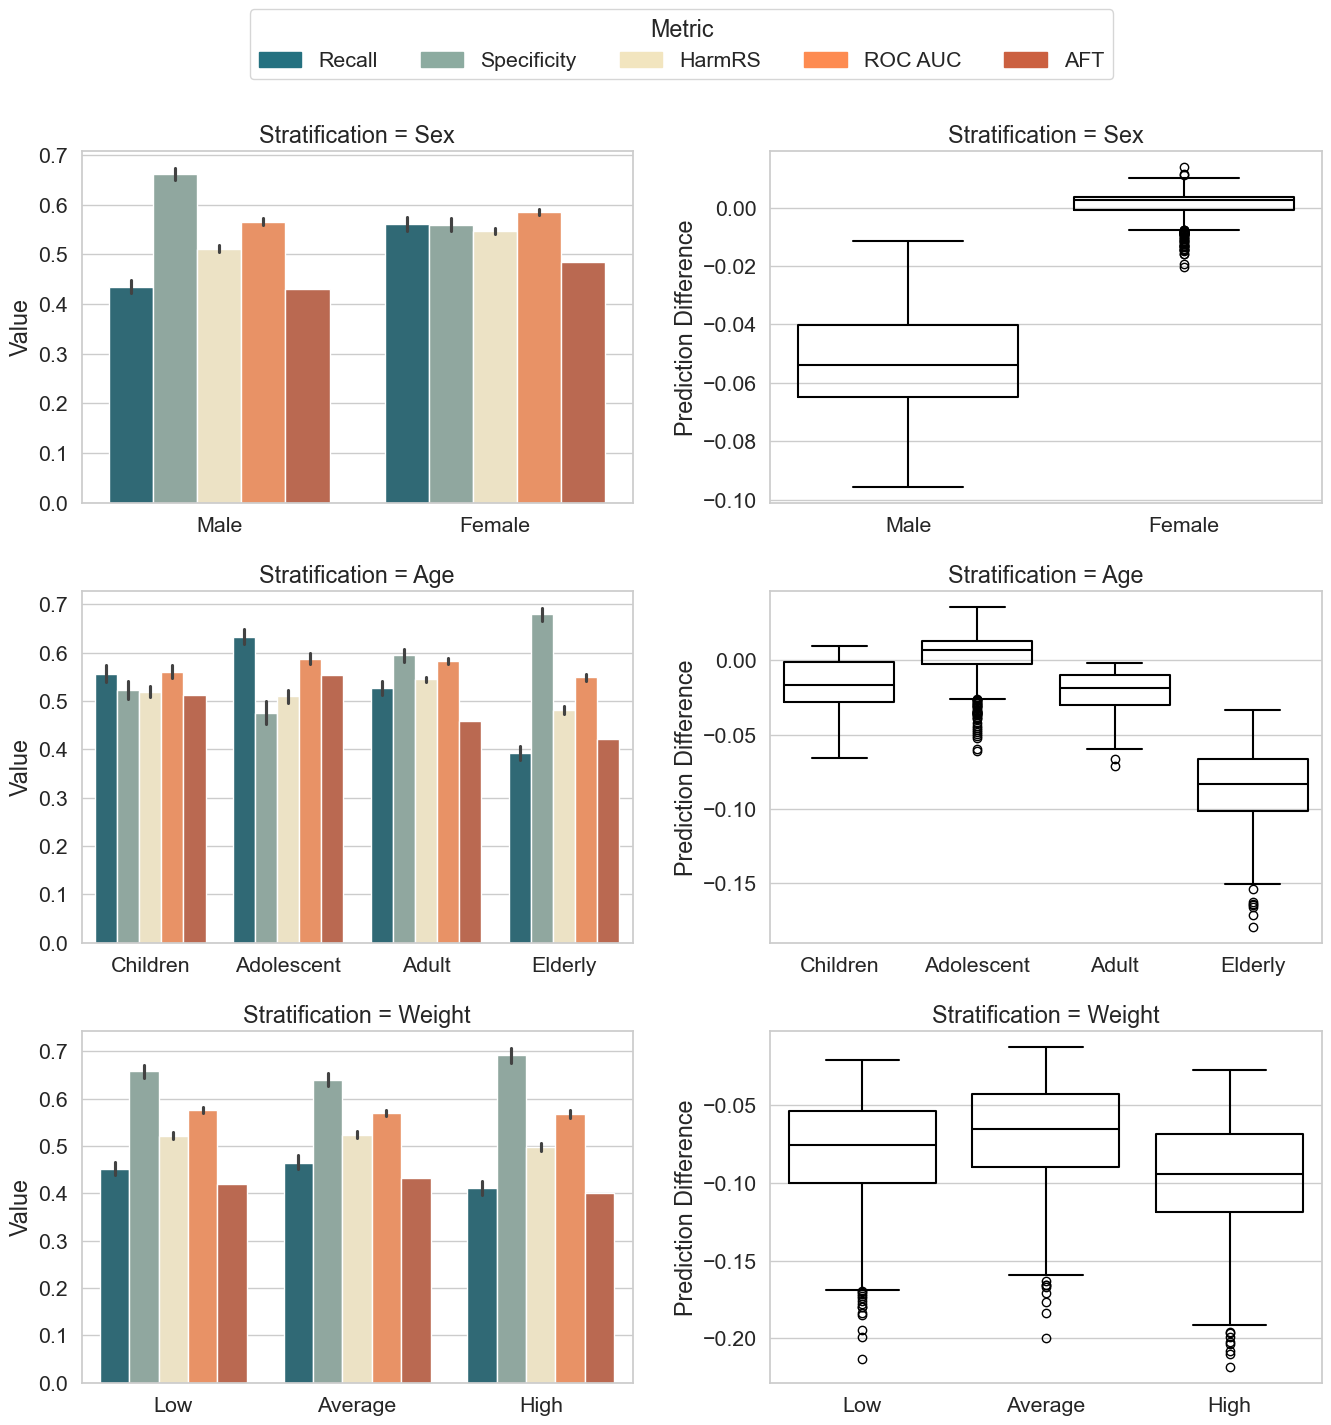

In [13]:
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')
set_font('arial.ttf')
sns.set_palette(four_point_palette())

colors = {
    'Recall': '#257180',
    'Specificity': '#8CABA0',
    'HarmRS': '#F2E5BF',
    'ROC AUC': '#FD8B51',
    'AFT': '#CB6040'
}

df_1 = pd.read_csv('../results/analysis/models_metrics.tsv', sep='\t')

df_2 = pl.read_csv('../results/analysis/prediction_differences.tsv', separator='\t')
df_2 = df_2.rename({'Category': 'Stratification', 'Difference': 'Prediction Difference'})

sex_df = df_1[df_1['Stratification'] == 'Sex'].reset_index(drop=True)
sex_df['Sub-category'] = sex_df['Sub-category'].astype(pd.CategoricalDtype(['Male', 'Female'], ordered=True))
sex_df = sex_df.dropna(subset='Sub-category')

age_df = df_1[df_1['Stratification'] == 'Age'].reset_index(drop=True)
age_df['Sub-category'] = age_df['Sub-category'].astype(pd.CategoricalDtype(['Children', 'Adolescent', 'Adult', 'Elderly'], ordered=True))
age_df = age_df.dropna(subset='Sub-category')

wgt_df = df_1[df_1['Stratification'] == 'Weight'].reset_index(drop=True)
wgt_df['Sub-category'] = wgt_df['Sub-category'].astype(pd.CategoricalDtype(['Low', 'Average', 'High'], ordered=True))
wgt_df = wgt_df.dropna(subset='Sub-category')

sns.set_context('notebook', font_scale=1.4)
sns.set_style('whitegrid')
set_font('arial.ttf')
sns.set_palette(five_point_palette())

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
sns.barplot(sex_df, x='Sub-category', y='Value', hue='Metric', ax=axes[0, 0], legend=False)
sns.barplot(age_df, x='Sub-category', y='Value', hue='Metric', ax=axes[1, 0], legend=False)
sns.barplot(wgt_df, x='Sub-category', y='Value', hue='Metric', ax=axes[2, 0], legend=False)

axes[0,0].set_xlabel('')
axes[0,0].set_title('Stratification = Sex')
axes[1,0].set_xlabel('')
axes[1,0].set_title('Stratification = Age')
axes[2,0].set_xlabel('')
axes[2,0].set_title('Stratification = Weight')

sns.boxplot(df_2.filter(pl.col('Stratification') == 'Sex'), x='Sub-category', y='Prediction Difference', ax=axes[0, 1], legend=False, fill=False, color='black')
sns.boxplot(df_2.filter(pl.col('Stratification') == 'Age'), x='Sub-category', y='Prediction Difference', ax=axes[1, 1], legend=False, fill=False, color='black')
sns.boxplot(df_2.filter(pl.col('Stratification') == 'Weight'), x='Sub-category', y='Prediction Difference', ax=axes[2, 1], legend=False, fill=False, color='black')

axes[0,1].set_xlabel('')
axes[0,1].set_title('Stratification = Sex')
axes[1,1].set_xlabel('')
axes[1,1].set_title('Stratification = Age')
axes[2,1].set_xlabel('')
axes[2,1].set_title('Stratification = Weight')

legend_patches = [Patch(color=colors[category], label=f'{category} ({category})') for category in ['Recall', 'Specificity', 'HarmRS', 'ROC AUC', 'AFT']]
legend_labels = ['Recall', 'Specificity', 'HarmRS', 'ROC AUC', 'AFT']
fig.legend(legend_patches, legend_labels, title='Metric', loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.975), bbox_transform=fig.transFigure)

plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.savefig('../figures/3_Models_Results.png', dpi=300, bbox_inches='tight')

## Supporting Figures

### Supporting Figure 1: Distribution of confidence scores based on DPA metric

In [ ]:
sns.set_context('notebook', font_scale=1.1)
sns.set_style('whitegrid')
set_font('arial.ttf')

comp_tuple = ('Unknown', 'Unknown', 'Unknown')

prim_ic_cred = read_df('../data/carbide/primary/Cred/carbide_ic.joblib')
prim_prr_cred = read_df('../data/carbide/primary/Cred/carbide_prr.joblib')
prim_ror_cred = read_df('../data/carbide/primary/Cred/carbide_ror.joblib')

pic = prim_ic_cred[prim_ic_cred['Signature'] == comp_tuple]['Label_weight']
ppc = prim_prr_cred[prim_prr_cred['Signature'] == comp_tuple]['Label_weight']
prc = prim_ror_cred[prim_ror_cred['Signature'] == comp_tuple]['Label_weight']

data = pd.DataFrame({
    'PRR': ppc,
    'ROR': prc,
    'IC': pic
})

colors = {
    'TP': '#257180',
    'TN': '#F2E5BF',
    'FP': '#FD8B51',
    'FN': '#CB6040'
}

melted_data = data.melt(var_name='Series', value_name='Value')

g = sns.FacetGrid(melted_data, col='Series', col_wrap=3, height=4, sharey=False)

g.map(sns.histplot, 'Value', bins=20, color='#CB6040', alpha=1, kde=False, stat='density')
g.map(sns.kdeplot, 'Value', color='#257180')

g.set_titles(col_template="{col_name}")
g.set_axis_labels("Confidence Score", "Density")
g.set(xlim=(0.1, 1.0))

plt.savefig('../figures/S1_Confidence_Scores.png', dpi=300)
plt.show()

### Supporting Figure 2: Models performance

Matplotlib is now using: Arial


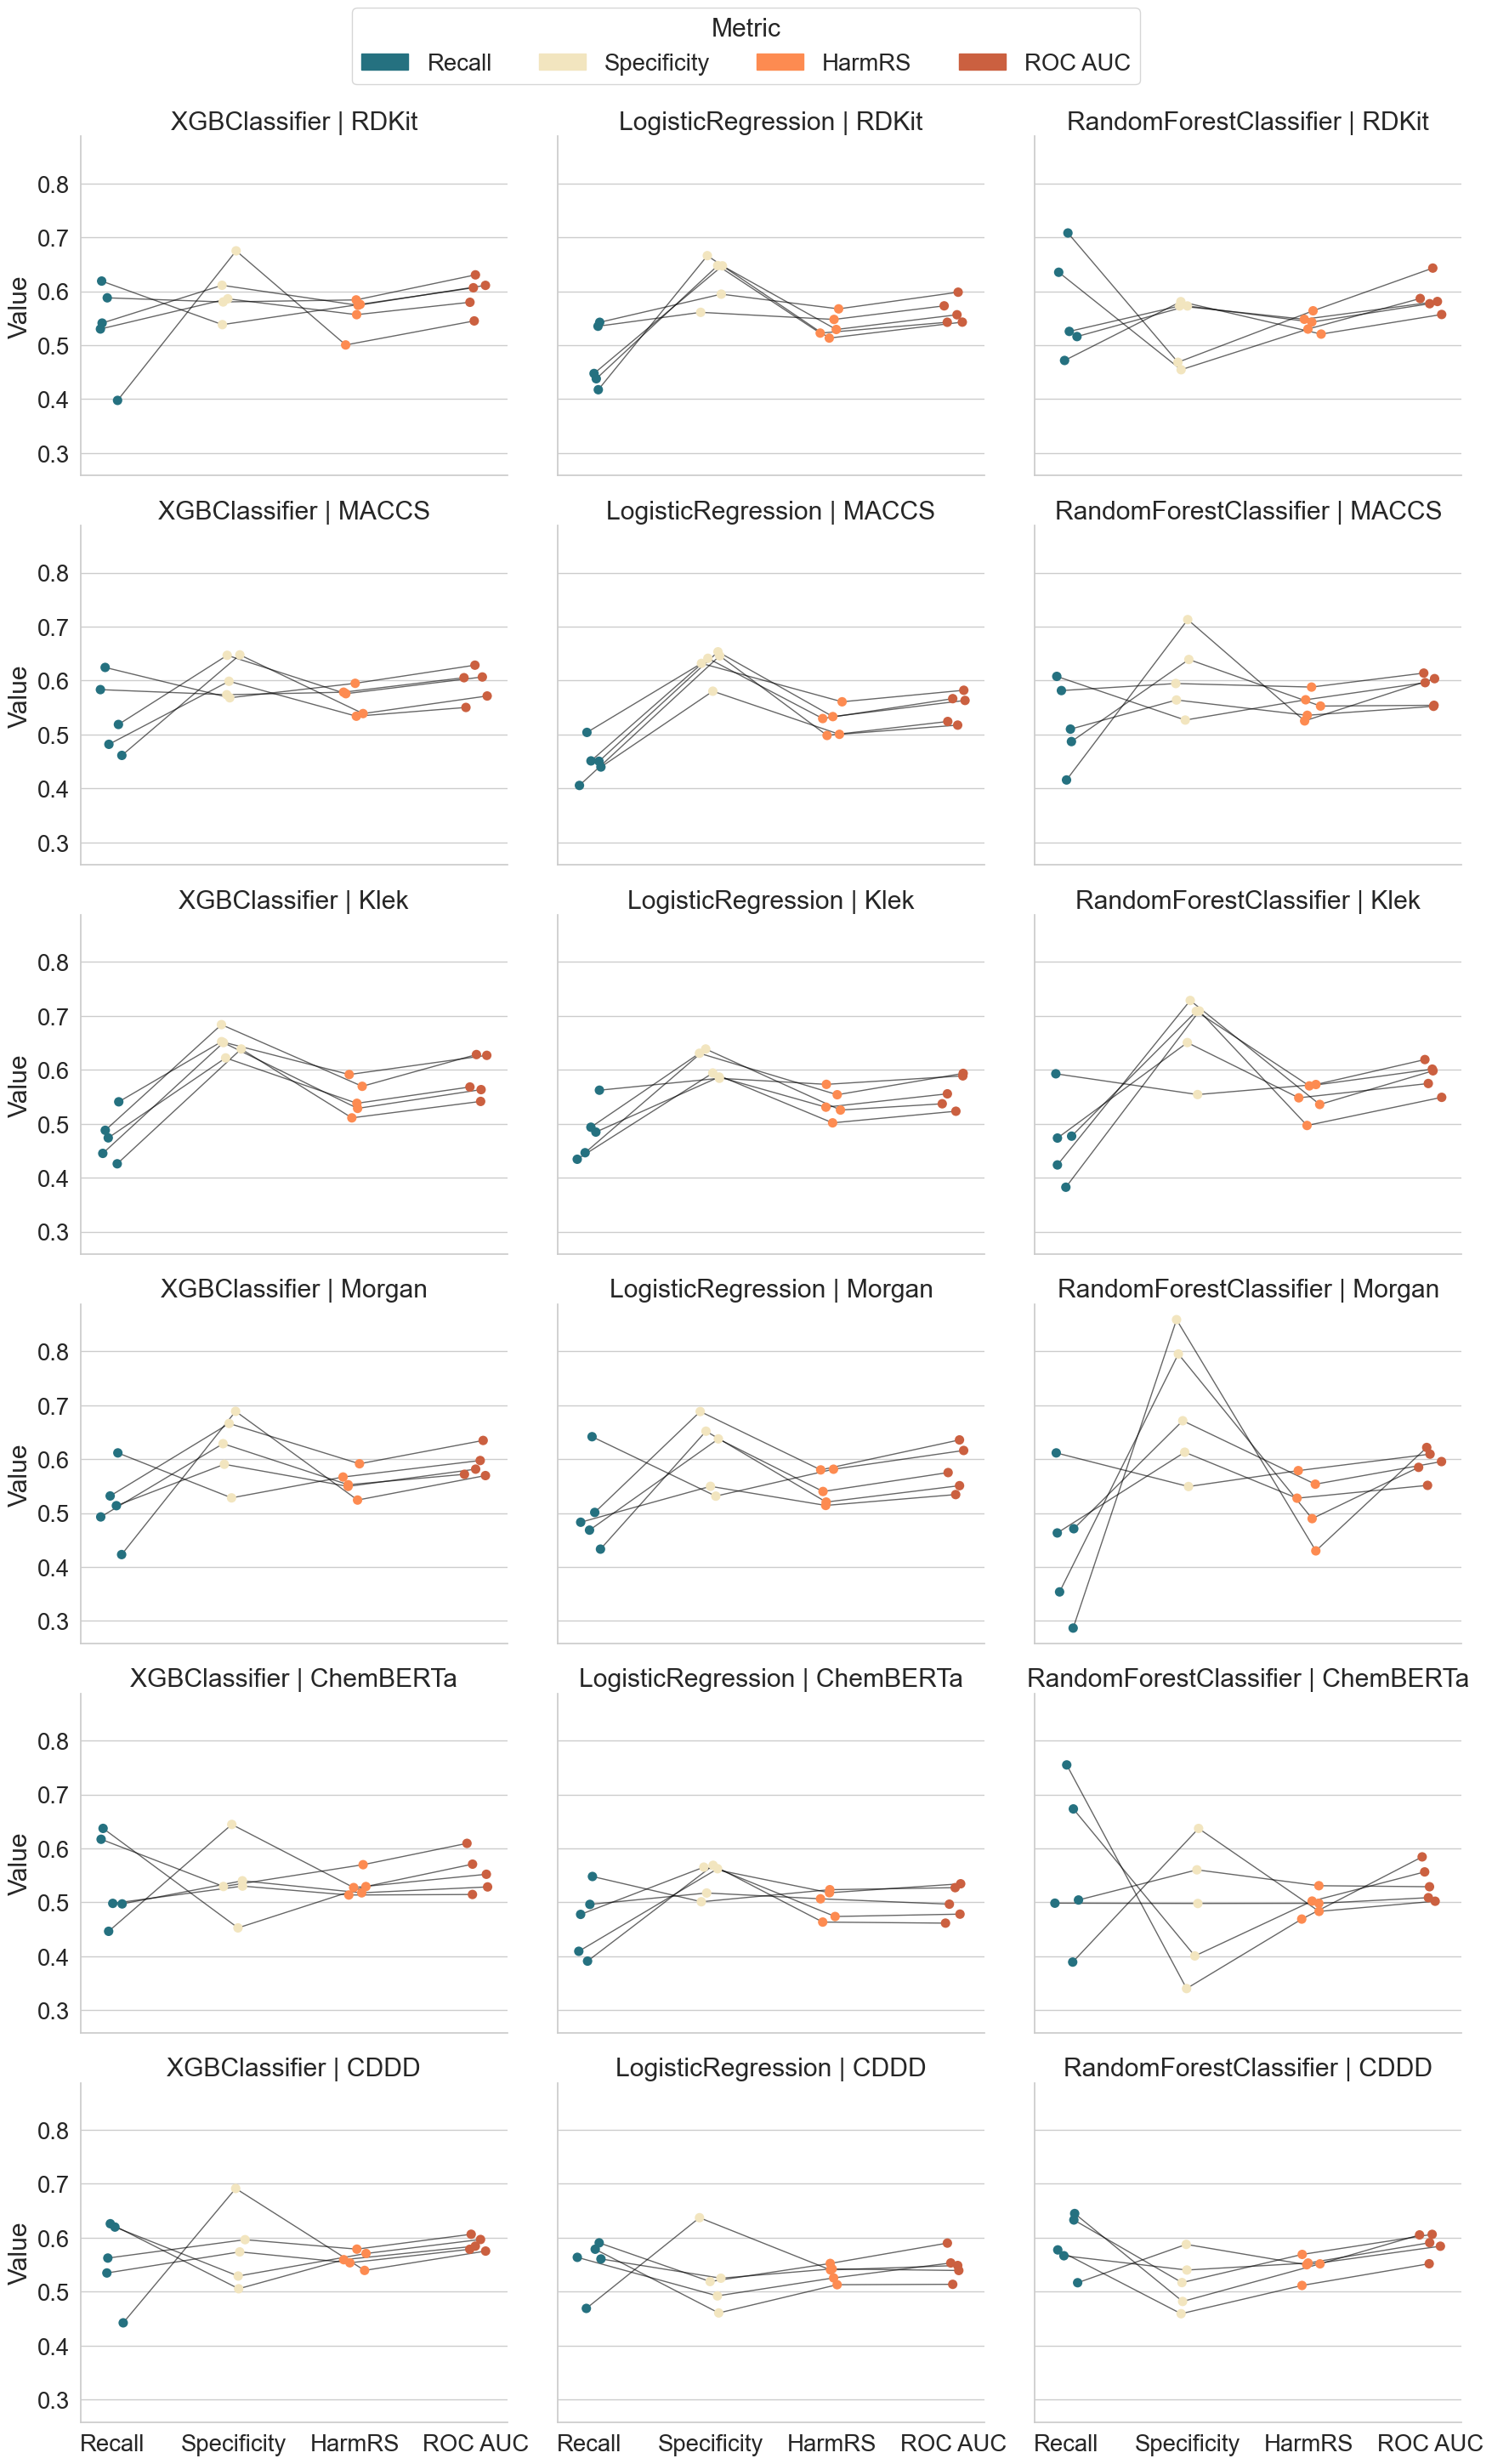

In [66]:
sns.set_context('notebook', font_scale=1.8)
sns.set_style('whitegrid')
set_font('arial.ttf')
sns.set_palette(four_point_palette())

df = pl.from_pandas(read_df('../results/analysis/total.tsv'))
df = df.filter(pl.col('Series') == 'Unweighted').drop('Series')

metric_order = ['Recall', 'Specificity', 'HarmRS', 'ROC AUC']

g = sns.FacetGrid(df, col='Model', row='Descriptors', height=5, aspect=1.2)

# plot points connected with lines
def plot_with_lines(data, x, y, **kwargs):
    ax = plt.gca()

    g_ = sns.stripplot(data=data, x=x, y=y, hue='Metric', size=8, dodge=False,
                       order=metric_order, palette=colors, ax=ax, zorder=2)

    point_positions = {}

    for i, metric in enumerate(metric_order):
        collection = ax.collections[i]
        offsets = collection.get_offsets()

        metric_data = data[data['Metric'] == metric].copy()
        metric_data = metric_data.sort_values('Value')
        sorted_offsets = offsets[np.argsort(offsets[:, 1])]

        for j, (_, row) in enumerate(metric_data.iterrows()):
            fold = row['Test_Fold']
            point_positions[(fold, metric)] = sorted_offsets[j]

    for fold in data['Test_Fold'].unique():
        x_positions = []
        y_values = []
        for metric in metric_order:
            if (fold, metric) in point_positions:
                pos = point_positions[(fold, metric)]
                x_positions.append(pos[0])
                y_values.append(pos[1])

        ax.plot(x_positions, y_values, color='black', alpha=0.6, lw=1, zorder=1)

g.map_dataframe(plot_with_lines, x='Metric', y='Value')

for ax in g.axes.flatten():
    ax_text = ax.get_title()
    desc, model = ax_text.split(' | ')
    desc = desc.split(' = ')[1].strip()
    model = model.split(' = ')[1].strip()
    ax.set_title(f"{model} | {desc}")


legend_patches = [Patch(color=colors[category], label=category) for category in metric_order]
g.figure.legend(handles=legend_patches, labels=metric_order, title='Metric',
                loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0.975),
                bbox_transform=g.figure.transFigure)

for ax in g.axes[-1, :]:
    ax.set_xlabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.savefig("../figures/S2_Performance.png", dpi=300, bbox_inches='tight')

plt.show()

### Supporting Figure 3: Recall-Specificity Ratio vs Adjusted Fraction Toxic

✔ Matplotlib is now using: Arial


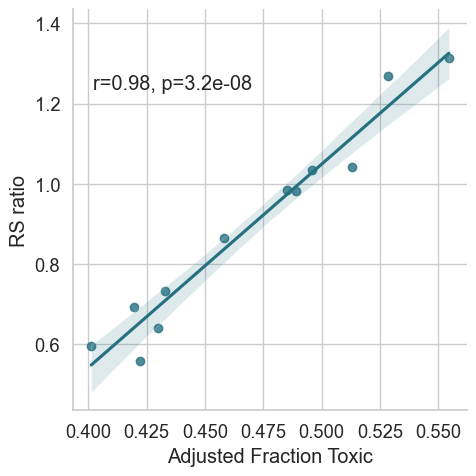

In [15]:
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')
set_font('arial.ttf')
sns.set_palette(four_point_palette())

df = pl.read_csv('../results/analysis/RS_ratio_analysis.tsv', separator='\t')

def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['Adjusted Fraction Toxic'], data['RS ratio'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)

g = sns.lmplot(df, x='Adjusted Fraction Toxic', y='RS ratio')
g.map_dataframe(annotate)
plt.ylabel("RS ratio")

plt.savefig('../figures/S3_RSratio_AFT.png', dpi=300, bbox_inches='tight')
plt.show()

### Supporting Figure 4: Weight Quantiles assignment criteria

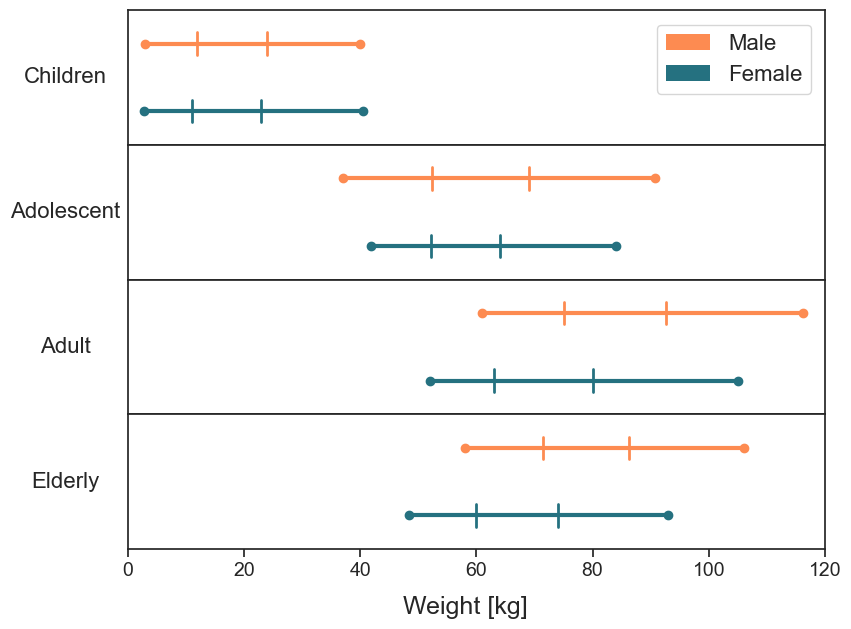

In [7]:
data = read_df('../data/mappings/wq_primary/wq_age_estim_sex_known.joblib').reset_index(name='quantiles')

sns.set_context('notebook')
sns.set_style('white')

c_m = '#FD8B51'
c_f = '#257180'

fig, axes = plt.subplots(nrows=4, sharex=True, figsize=(9, 7))
fig.subplots_adjust(hspace=0)
age_groups = ['Children', 'Adolescent', 'Adult', 'Elderly']

for i, (ax, age) in enumerate(zip(axes, age_groups)):
    m = data[(data.age_group == age) & (data.sex == 'M')]['quantiles'].values[0]
    f = data[(data.age_group == age) & (data.sex == 'F')]['quantiles'].values[0]

    # Assuming m and f are 1D arrays of 4 quantiles
    ax.plot([m[0], m[-1]], [3/4, 3/4], label='Male', color=c_m, linewidth=3)
    ax.plot([f[0], f[-1]], [1/4, 1/4], label='Female', color=c_f, linewidth=3)

    ax.axvline(m[1], ymin=3/4 - 1/12, ymax=3/4 + 1/12, color=c_m, linewidth=2)
    ax.axvline(m[2], ymin=3/4 - 1/12, ymax=3/4 + 1/12, color=c_m, linewidth=2)

    ax.axvline(f[1], ymin=1/4 - 1/12, ymax=1/4 + 1/12, color=c_f, linewidth=2)
    ax.axvline(f[2], ymin=1/4 - 1/12, ymax=1/4 + 1/12, color=c_f, linewidth=2)

    ax.plot(m[0], 3/4, 'o', color=c_m)
    ax.plot(m[-1], 3/4, 'o', color=c_m)
    ax.plot(f[0], 1/4, 'o', color=c_f)
    ax.plot(f[-1], 1/4, 'o', color=c_f)

    ax.set_ylim(0,1)
    ax.set_xlim(0, 120)

    if i == 3:
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=14)

    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.set_ylabel(age, rotation=0, labelpad=45, va='center', fontsize=16)


legend_elements = [
    Patch(facecolor=c_m, edgecolor='none', label='Male'),
    Patch(facecolor=c_f, edgecolor='none', label='Female')
]

fig.legend(handles=legend_elements, ncol=1, frameon=True, bbox_to_anchor=(0.897, 0.875), fontsize=16)
fig.supxlabel("Weight [kg]", fontsize=18)

plt.savefig('../figures/S4_Weight_Quantiles.png', dpi=300, bbox_inches='tight')
plt.show()

### Supporting Figure 5: Inter-fold Minimum Tanimoto Distance KDE Plots

✔ Matplotlib is now using: Arial


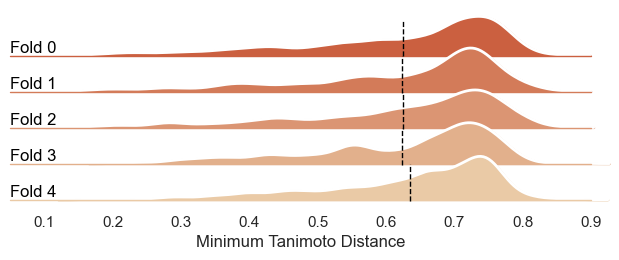

In [8]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context(font_scale=1.3)
set_font('arial.ttf')

df = read_df('../data/mappings/data_splits.tsv')
df = dataframe_2_morgan(df)

fold_dists = {}

for fold in df.Fold.unique():
    xa = np.vstack(df[df.Fold == fold].Morgan.to_numpy())
    xb = np.vstack(df[df.Fold != fold].Morgan.to_numpy())
    dist_array = cdist(xa, xb, 'jaccard')
    min_dist_array = dist_array.min(axis=1)
    fold_dists[fold] = min_dist_array

plot_df = pd.DataFrame([
    {"Fold": fold, "Distance": val}
    for fold, arr in fold_dists.items()
    for val in arr
])

palette = {0: '#CB6040', 1: '#D37B59', 2: '#DB9573', 3: '#E2B08C', 4: '#EACAA6', 5: '#F2E5BF'}

g = sns.FacetGrid(plot_df, row="Fold", hue="Fold", aspect=15, height=0.5, palette=palette)

g.map(sns.kdeplot, "Distance",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Distance", clip_on=False, color="white", lw=2, bw_adjust=.5)

g.refline(y=-0.045, linewidth=1, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, f'Fold {label}', color='black',
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Distance")

def mean_line(data, color, **kwargs):
    ax = plt.gca()
    mean_val = data["Distance"].mean()
    ax.axvline(ymin=0.03, ymax=0.79, x=mean_val, color='black', linestyle='--', linewidth=1)

g.map_dataframe(mean_line)

g.figure.subplots_adjust(hspace=-0.25)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim=(0.05, 0.9))

plt.xlabel("Minimum Tanimoto Distance")
plt.savefig('../figures/S5_KDE_Plots.png', dpi=300, bbox_inches='tight')

plt.show()

### Supporting Figure 6: UMAP embedding of folds

✔ Matplotlib is now using: Arial


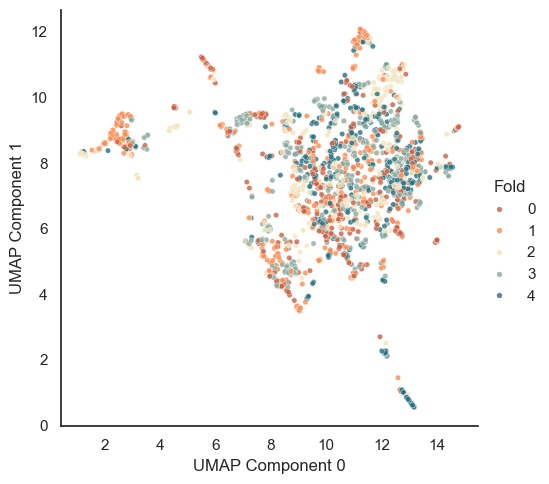

In [11]:
sns.set_context('notebook', font_scale=1.1)
sns.set_style('whitegrid')
set_font('arial.ttf')
palette = {idx: value for idx, value in enumerate(five_point_palette()[::-1])}

df = read_df('../data/mappings/data_splits.tsv')
df = dataframe_2_morgan(df, radius=2, nbits=4096)

umap_plot(df, fp_col='Morgan', hue_col='Fold', save_path='../figures/S6_UMAP.png', plot_kwargs={'palette': palette, 's': 15})

In [1]:
# Supporting Figure 7 made using InkScape

### Supporting Figure 8: Modified Sigmoid Function

✔ Matplotlib is now using: Arial


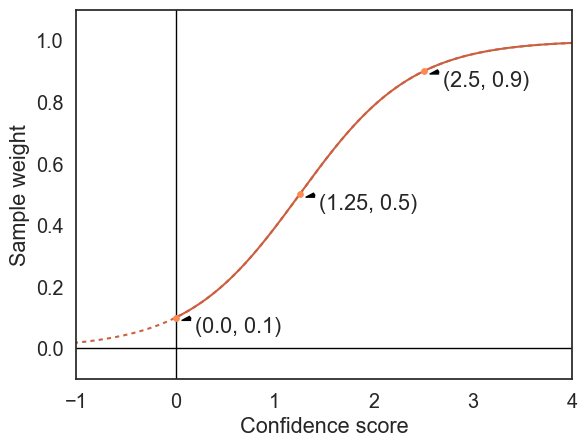

In [10]:
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white')
set_font('arial.ttf')

def sigmoid(x, saturation: float = 2.5):
    """
    Modified sigmoid. Parameter saturation gives the position at which the function reaches 0.9.
    """
    alpha = -2 / saturation * np.log(9)
    beta = saturation / 2

    value = 1 / (1 + np.exp(alpha * (x - beta)))
    return np.round(value, 5)

arrowprop = {
    "color": 'black',
    "width": 0.8,
    "headwidth": 3,
    "headlength": 6,
    "shrink": 0.1
}

xs_1 = np.arange(0, 5, 0.01)
xs_2 = np.arange(-2, 5, 0.01)
ys_1 = sigmoid(xs_1, saturation=2.5)
ys_2 = sigmoid(xs_2, saturation=2.5)

ax1 = sns.lineplot(data=None, x=xs_1, y=ys_1, color='#CB6040')
ax2 = sns.lineplot(data=None, x=xs_2, y=ys_2, dashes=(2,2), color='#CB6040')
plt.hlines(y=0, xmin=-3, xmax=6, colors='black', linewidth=1)
plt.vlines(x=0, ymin=-1, ymax=2, colors='black', linewidth=1)
plt.ylim(-0.1, 1.1)
plt.xlim(-1, 4)
plt.xlabel('Confidence score')
plt.ylabel('Sample weight')
plt.annotate(text='(0.0, 0.1)', xy=(0.05, 0.09), xytext=(0.2, 0.05), arrowprops=arrowprop)
plt.annotate(text='(1.25, 0.5)', xy=(1.30, 0.49), xytext=(1.45, 0.45), arrowprops=arrowprop)
plt.annotate(text='(2.5, 0.9)', xy=(2.55, 0.89), xytext=(2.70, 0.85), arrowprops=arrowprop)
plt.scatter(x=[0.0, 1.25, 2.50], y=[0.1, 0.5, 0.9], zorder=3, color='#FD8B51', s=15)
plt.savefig('../figures/S8_Sigmoid_Function.png', dpi=300, bbox_inches='tight')
plt.show()